# Metadata

- Created: 2022-08-27
- Last modified: 2022-08-30
- Author: Daniel Kaiser
- Project Identifiers: EMB_ex01
- Last read and understood by: ???
- Changelog:
    - (2022-08-27) Initialized notebook
    - (2022-08-27) Formatted experiment workflow
    - (2022-08-28) Reworked source code, updated workflow drivers
    - (2022-08-29) Converted project repository to Snakemake workflow (started running large sweep on HPC)
    - (2022-08-30) Ran small experiment here, updated documentation
    - (2022-08-30) Minor versioning updates

# Preface

## Experiment protocol

<!-- Yes, I know the &nbsp is annoying, tabs are automatically removed in basic markdown ok -->
<u>**Experiment ID and project**</u>

EMB_ex01

<u>**Date designed and version**</u>

- 2022-08-27v1.0
- 2022-08-28v1.1
- 2022-08-29v2.0
- 2022-08-30v2.1

<u>**Date conducted**</u>

- 2022-08-30v2.0
- 2022-08-30v2.1

<u>**Researcher(s)**</u>

Daniel Kaiser

<u>**Description**</u>

**Purpose**

This experiment is designed to explore the accuracy of multiplex reconstruction utilizing Euclidean distance as a proxy for the likelihood of edge-layer placement. Embedding the "remnant" of each layer of a XOR-aggregated duplex (scale-free layers, configurable edge correlation), an edge to be classified from the aggregate is predicted to originate from the layer whose remnant embedding yields a smaller distance of the edge endpoints.

**Hypothesis (if applicable)**

The expected outcome of this experiment is an AUROC curve of classification that is an increasing function of PFI, decreasing function of degree homogeneity and edge correlation. Note this matches the high-level qualitative results of the naive Bayes approach used in earlier work. (Project identifier "MEC")

<u>**Data & Code**</u>

**Prerequisite data (if applicable)**

This experiment measures AUROC on synthetic, configurable scale-free duplexes. The layers of the duplex are generated according to `Utils.py:generate_multiplex_configuration(N, gamma, kmin, kmax, prob, sign)`. The configurable parameters are:

- N; number of nodes (forced exact node overlap in layers)
- gamma; scale-free parameter of degree distribution
- kmin; enforced minimum node degree
- kmax; enforced maximum node degree (structural cut-off)
- prob; probability any given node degree is swapped with another random node's degree from layer $\alpha$. Applied to all of $\alpha$, samples the other layer of duplex, $\beta$.
- sign; controls the sorting before degree re-assignment procedure. -1 corresponds to anti-correlation, 1 to correlation
    - prob=0, sign=-1 is perfectly anti-correlated degree sequences
    - prob=0, sign=1 is perfectly correlated degree sequences (exact same!)
    - prob=1, sign=-1 or 1 are two random draws from same degree distribution (characterized by $\gamma$)


**Resultant data**

The resultant data is in the form of a dataframe with columns:
- N
- gamma
- kmin
- prob
- sign
- pfi
- Accuracy
- dimensions
- walk_length
- num_walks
- workers
- window
- min_count
- batch_words

Optionally, the node embeddings for each layer of the duplexes associated to each of these dataframe records can be saved as well. They should be saved as pickled numpy arrays of size (N, dimensions).

**Code**

This experiment relies on the script `Utils.py` or functions in this document. All code from `Utils.py` is original or only slightly modified MEC code from @Filippo Radicchi.

@Elior Cohen and node2vec's [GitHub repo](https://github.com/eliorc/node2vec) inspired the function `embed_system`.

Some package version updates in Gensim forced some adjustments - thanks to @555wen on [this StackExchange post](https://stackoverflow.com/questions/67413006/typeerror-init-got-an-unexpected-keyword-argument-size) from @yinky for pointing out a parameter name change. In the site-packages for node2vec, `node2vec.py:175` was altered from `if 'size' not in skip_gram_params:` to `if 'vector_size' not in skip_gram_params:`and `node2vec.py:176` was altered from `skip_gram_params['size'] = self.dimensions` to `skip_gram_params['vector_size'] = self.dimensions`.

<u>**Procedure**</u>

The following procedure was conducted to run this experiment and is sufficient to replicate the workflow along with code described in the "Code" section above.
1. Generate duplex, $\mathcal{M} = (V, (\alpha, \beta))$
2. Aggregate duplex into a monoplex, $G$, and observe some partial information for each layer $\mathcal{O}_{\alpha}, \mathcal{O}_{\beta}$
3. Create remnants by $\mathcal{R}_{\alpha} = G \setminus \mathcal{O}_{\alpha}, \mathcal{R}_{\beta} = G \setminus \mathcal{O}_{\beta}$
4. Embed $\mathcal{R}_{\alpha}, \mathcal{R}_{\beta}$ separately using node2vec. Call the resultant embedded points $\mathcal{D}_{\alpha}, \mathcal{D}_{\beta}$.
5. For $(i, j) \in G \setminus (\mathcal{O}_{\alpha} \cup \mathcal{O}_{\beta})$, classify $(i,j)$ as having originated from layer
$$
\hat{l}_{ij} = \text{argmin}_{\gamma \in \{\alpha, \beta \}} \| \mathcal{D}_{\gamma}(i) - \mathcal{D}_{\gamma}(j) \|
$$
6. Calling the true originating layer of $(i, j) \in G \setminus (\mathcal{O}_{\alpha} \cup \mathcal{O}_{\beta})$ as $l_{ij}$, measure $\| l - \hat{l} \|$
    - NOTE: Since this is a binary classification problem, we actually elect to use the AUROC of the classification of $(i,j) \mapsto \hat{l}_{ij}$ with ground truth $l_{ij}$. The vector norm is simply a more general form of measuring "difference" in our classifications and the ground truth.

## Theoretical foundations and symbol/prior result guide

Will eventually ill in with background from project "MEC" but I am being lazy tbh...

## Setup

### Imports

In [1]:
# --- Standard library ---
import os
import sys
sys.path.append("../src/")
import yaml
from datetime import datetime
from copy import deepcopy

# --- Scientific ---
import numpy as np
from sklearn import metrics

# --- Network science ---
from node2vec import Node2Vec as N2V
import networkx as nx
from Utils import *

# --- Data handling and visualization ---
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# --- Miscellaneous ---
from tqdm.auto import tqdm

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg', 'karateclub', 'infomap', 'graph_tool'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'infomap'}


### Globals

In [38]:
# --- Other import aliases ---
today = datetime.today

# --- Visualization ---
rc_dict = {
#   "savefig.dpi": 600,  # Saved figure dots-per-inch. 600 is "HD"
  "savefig.facecolor": "white",  # This, combined with transparent setting, keeps saved figs from looking like trash on dark backgrounds 
  "savefig.transparent": False,
#   "figure.figsize": (14, 10),  # Default (width, height) of figure
}
plt.rcParams.update(rc_dict)


# --- Pathing ---
raw = "../results/raw/"
processed = "../results/processed/"
figures = "../results/plots/"
config_ = "../workflow/config_.yaml"

# --- Versioning ---
current_version = "v2.1"
researcher_initials = "DK"
date = today().strftime("%Y%m%d")

# Experiment

## Setup

### Functions

In [3]:
# * Functions defined here should, like classes, primarily be helper functions
# * for this particular experiment. Functions used repeatedly throughout a project
# * should be written as source code and imported here.
def form_system(params):
    # Process parameters
    N, gamma, kmin, prob, sign = params["N"], params["gamma"], params["kmin"], params["prob"], params["sign"]
    pfi = params["pfi"]
    kmax = np.sqrt(N)

    # Form "raw" duplex
    D = generate_multiplex_configuration(N, gamma, kmin, kmax, prob, sign)

    # Split into layers
    G, H = duplex_network(D, 1, 2)

    # Observe partial information
    R_G, R_H, agg = partial_information(G, H, pfi)

    return G, H, R_G, R_H, agg

def embed_system(R_G, R_H, params):
    # Process parameters
    dimensions, walk_length, num_walks = params["dimensions"], params["walk_length"], params["num_walks"]
    workers, window, min_count, batch_words = params["workers"], params["window"], params["min_count"], params["batch_words"]

    # Generate walks
    R_G_emb = N2V(R_G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers, quiet=True).fit(window=window, min_count=min_count, batch_words=batch_words)
    R_H_emb = N2V(R_H, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers, quiet=True).fit(window=window, min_count=min_count, batch_words=batch_words)

    # Retrieve embedded models
    G_ = R_G_emb.wv
    H_ = R_H_emb.wv

    return G_, H_

def check_accuracy(G, H, agg, G_, H_):
    cls = []
    scores = []
    gt = []
    for src, tgt in agg:
        v_G_src = G_[src, :]
        v_G_tgt = G_[tgt, :]
        v_H_src = H_[src, :]
        v_H_tgt = H_[tgt, :]

        d_G = np.linalg.norm(v_G_src - v_G_tgt)
        d_H = np.linalg.norm(v_H_src - v_H_tgt)
        t_G = d_G / (d_G + d_H)
        t_H = 1 - d_H

        scores.append(t_G)

        if t_G > t_H:
            cls.append(0)
        elif t_H > t_G:
            cls.append(1)
        else:
            cls.append(np.random.randint(0, 2))

        if (src, tgt) in G.edges():
            gt.append(0)
        else:
            gt.append(1)

    acc = metrics.accuracy_score(gt, cls)
    auroc = metrics.roc_auc_score(gt, scores)
    return acc, auroc

### Configuration

In [4]:
# * YAML configuration files are recommended
with open(config_, 'r') as _fh:
    config = yaml.safe_load(_fh)

# Convenience aliasing for datafile config
save_ = config["workflow"]["datafiles"]["KEEP_EMBEDDINGS"]
template_ = config["workflow"]["datafiles"]["TEMPLATE"].format(current_version=current_version, researcher_initials=researcher_initials, date=date)
vector_template_ = "{}/{}-vectors_N={}_gamma={}_kmin={}_prob={}_sign={}_pfi={}_repetition={}.mat"

### Workflow

In [5]:
# * Run any driver code here. It is recommended to return the most "raw"
# * potential and apply any necessary post-processing separately.
def _process_grid(config):
    # Process parameter grid
    grid = []
    params = {
        # Network parameters
        "N": 0,
        "gamma": 0,
        "kmin": 0,
        "prob": 0,
        "sign": 0,
        "pfi": 0,
        # Embedding parameters
        "dimensions": config["embedding"]["dimensions"],
        "walk_length": config["embedding"]["walk_length"],
        "num_walks": config["embedding"]["num_walks"],
        "workers": config["embedding"]["workers"],
        "window": config["embedding"]["window"],
        "min_count": config["embedding"]["min_count"],
        "batch_words": config["embedding"]["batch_words"],
    }
    for N_ in config["network"]["N"]:
        for gamma_ in config["network"]["gamma"]:
            for kmin_ in config["network"]["kmin"]:
                for prob_ in config["network"]["prob"]:
                    for sign_ in config["network"]["sign"]:
                        for pfi_ in config["network"]["pfi"]:
                            for repetition_ in config["network"]["repetitions"]:
                                params_ = deepcopy(params)
                                params_["N"] = N_
                                params_["gamma"] = gamma_
                                params_["kmin"] = kmin_
                                params_["prob"] = prob_
                                params_["sign"] = sign_
                                params_["pfi"] = pfi_
                                params_["repetition"] = repetition_
                                grid.append(params_)

    return grid

def workflow(config):
    # Process parameter grid
    grid = _process_grid(config)

    # Prepare results dataframe (dict)
    df_ = {key: [] for key in grid[0].keys()}
    df_["Accuracy"] = []
    df_["AUROC"] = []

    # Run experiment
    for gv in tqdm(grid):
        # Track parameters
        for key, value in gv.items():
            df_[key].append(value)

        # Generate synthetic system and form remnants
        G, H, R_G, R_H, agg = form_system(gv)

        # Apply node2vec
        G_, H_ = embed_system(R_G, R_H, gv)

        # Save embedding, if applicable
        if save_:
            for (model, name) in ((G_, "original"), (H_, "shuffled")):
                model.save_word2vec_format(
                    vector_template_.format(
                        raw, name,
                        gv["N"], gv["gamma"], gv["kmin"],
                        gv["prob"], gv["sign"],
                        gv["pfi"],
                        gv["repetition"]
                    )
                )

        # Measure performance
        accuracy, auroc = check_accuracy(G, H, agg, G_.vectors, H_.vectors)

        # Update performance measure columns
        df_["Accuracy"].append(accuracy)
        df_["AUROC"].append(auroc)

    # Format dataframe and save
    df = pd.DataFrame(df_)
    df.to_csv(f"{raw}/{template_}.csv")

    return df

## Computations

In [6]:
workflow(config)

100%|██████████| 48/48 [1:42:36<00:00, 128.27s/it]


,N,gamma,kmin,prob,sign,pfi,dimensions,walk_length,num_walks,workers,window,min_count,batch_words,repetition,Accuracy,AUROC
0,500,2.0,3,0.00,-1,0.33,128,30,100,8,10,1,4,1,0.504382,0.520207
1,500,2.0,3,0.00,-1,0.67,128,30,100,8,10,1,4,1,0.497087,0.480654
2,500,2.0,3,0.00,-1,0.95,128,30,100,8,10,1,4,1,0.518750,0.464716
3,500,2.0,3,0.00,1,0.33,128,30,100,8,10,1,4,1,0.495744,0.503247
4,500,2.0,3,0.00,1,0.67,128,30,100,8,10,1,4,1,0.500904,0.495546
5,500,2.0,3,0.00,1,0.95,128,30,100,8,10,1,4,1,0.484076,0.498213
6,500,2.0,3,0.33,-1,0.33,128,30,100,8,10,1,4,1,0.503861,0.497156
7,500,2.0,3,0.33,-1,0.67,128,30,100,8,10,1,4,1,0.512097,0.532464
8,500,2.0,3,0.33,-1,0.95,128,30,100,8,10,1,4,1,0.509202,0.421235
9,500,2.0,3,0.33,1,0.33,128,30,100,8,10,1,4,1,0.486817,0.511160


# Analysis

In [11]:
# Uncomment if resuming analysis from after experiment was ran
df = pd.read_csv(f"{raw}/EMB_ex01v2.1_node2vec_remnants_DK_20220830.csv")
print(df.columns)

Index(['Unnamed: 0', 'N', 'gamma', 'kmin', 'prob', 'sign', 'pfi', 'dimensions',
       'walk_length', 'num_walks', 'workers', 'window', 'min_count',
       'batch_words', 'repetition', 'Accuracy', 'AUROC'],
      dtype='object')


## Post-processing data

## Visualization

### Initial exploration

<Figure size 640x480 with 0 Axes>

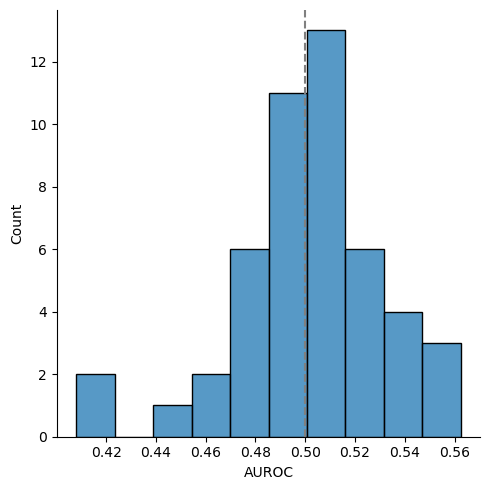

In [59]:
# Declare figure
plt.figure()
figure_ = sns.displot(
    data=df, kind="hist",
    x="AUROC"
)

# Format figure
figure_ = (
    figure_
    .refline(x=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/hist_auroc_EMB_ex01{current_version}_{researcher_initials}_{date}.png")
figure_

<Figure size 640x480 with 0 Axes>

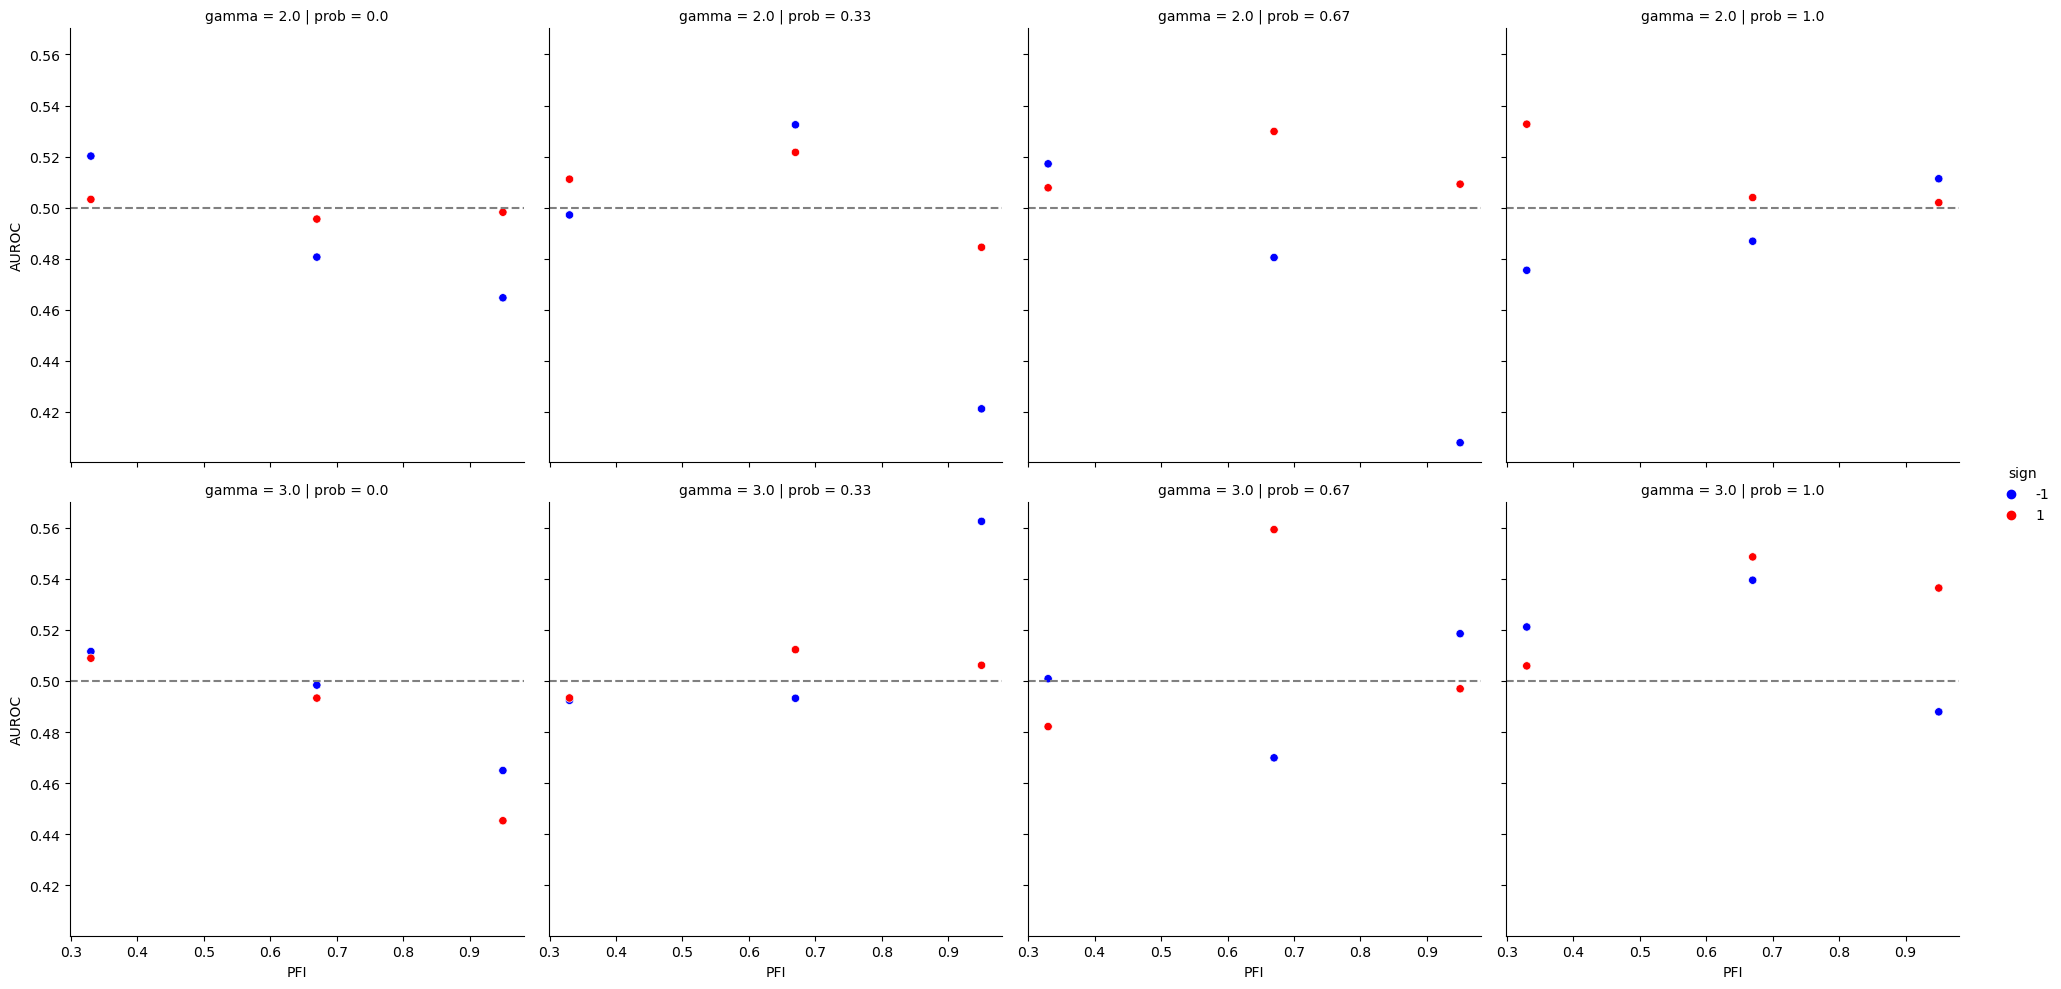

In [40]:
# Declare figure
plt.figure()
figure_ = sns.relplot(
    data=df, kind="scatter",
    x="pfi", y="AUROC",
    row="gamma",
    col="prob",
    hue="sign", palette=["blue", "red"]
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("PFI", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/faceted-scatter_auroc-pfi-gamma-prob-sign_EMB_ex01{current_version}_{researcher_initials}_{date}.png")
figure_

### Effect of PFI

<Figure size 640x480 with 0 Axes>

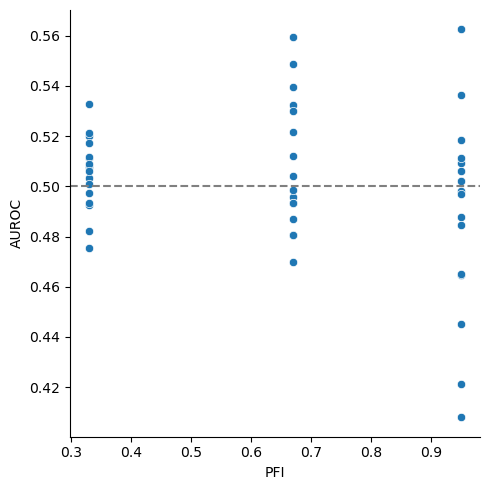

In [42]:
# Declare figure
plt.figure()
figure_ = sns.relplot(
    data=df, kind="scatter",
    x="pfi", y="AUROC",
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("PFI", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/scatter_auroc-pfi_EMB_ex01{current_version}_{researcher_initials}_{date}.png")
figure_

### Effect of degree heterogeneity ($\gamma$)

<Figure size 640x480 with 0 Axes>

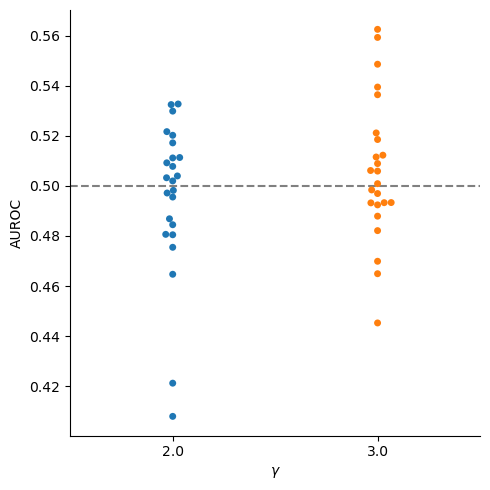

In [48]:
# Declare figure
plt.figure()
figure_ = sns.catplot(
    data=df, kind="swarm",
    x="gamma", y="AUROC",
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("$\gamma$", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/swarm_auroc-gamma_EMB_ex01{current_version}_{researcher_initials}_{date}.png")
figure_

<Figure size 640x480 with 0 Axes>

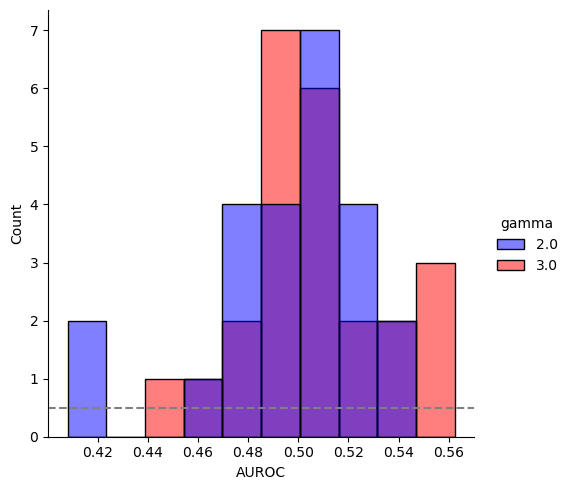

In [58]:
# Declare figure
plt.figure()
figure_ = sns.displot(
    data=df, kind="hist",
    x="AUROC",
    hue="gamma", palette=["blue", "red"]
)

# Format figure
figure_ = (
    figure_
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/hist_auroc-gamma_EMB_ex01{current_version}_{researcher_initials}_{date}.png")
figure_

### Effect of correlation prob

<Figure size 640x480 with 0 Axes>

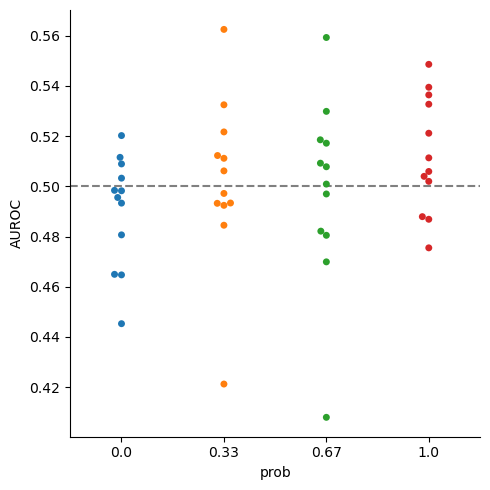

In [49]:
# Declare figure
plt.figure()
figure_ = sns.catplot(
    data=df, kind="swarm",
    x="prob", y="AUROC",
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("prob", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/swarm_auroc-prob_EMB_ex01{current_version}_{researcher_initials}_{date}.png")
figure_

### Effect of sorting (sign)

<Figure size 640x480 with 0 Axes>

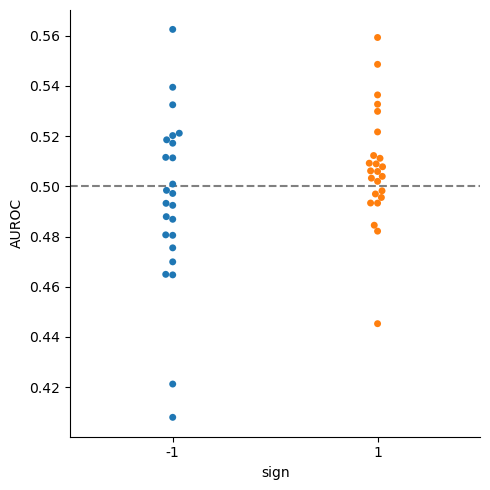

In [52]:
# Declare figure
plt.figure()
figure_ = sns.catplot(
    data=df, kind="swarm",
    x="sign", y="AUROC",
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("sign", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/swarm_auroc-sign_EMB_ex01{current_version}_{researcher_initials}_{date}.png")
figure_

<Figure size 640x480 with 0 Axes>

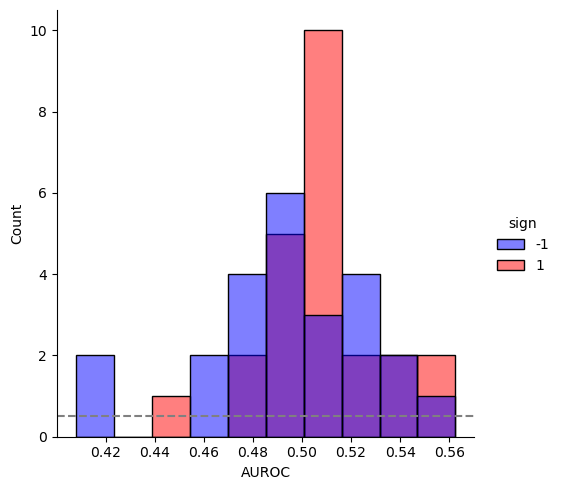

In [57]:
# Declare figure
plt.figure()
figure_ = sns.displot(
    data=df, kind="hist",
    x="AUROC",
    hue="sign", palette=["blue", "red"]
)

# Format figure
figure_ = (
    figure_
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/hist_auroc-sign_EMB_ex01{current_version}_{researcher_initials}_{date}.png")
figure_

# Discussion

## Observations

Currently, the AUROC seems to be centered about 0.5 regardless of parameters.

## Interpretations

The clear centering of $AUROC \approx 0.5$ suggests that there is no noticeable effect from the parameters of the duplex. This certainly seems nonsensical, suggesting some bug.

My current best theory is that we are encountering the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) - given the large dimension of the embedded space, all points have only minute distinguishability of distances between the layer embeddings, leading to, up to machine precision, more or less a random guess. Given the mean of the AUROC distribution is also around 0.5, the expected mean of randomly guessing given our duplex configurations (same total degree), this suggests we are not doing better than random guessing because we *are* effectively randomly guessing.

## Follow-up

The next step would be to implement a projection into a lower dimensional space and try again. I will start with what I think is commonplace for these sorts of analyses, namely, a 2-dimensional PCA.


Given this is the addition of a new _computational_ step in the pipeline, I will implement this into a new experiment, "EMB_ex02"